# 03 – Modelado Predictivo (Telco Customer Churn)  
**Construcción, evaluación y optimización de modelos para predecir el abandono de clientes**

## Introducción

Una vez que los datos han sido limpiados y preparados, el siguiente paso es desarrollar modelos de Machine Learning que permitan predecir el *churn* con precisión. Para ello, se entrenarán diversos algoritmos de clasificación, se evaluará su desempeño mediante métricas relevantes, y se ajustarán sus hiperparámetros para maximizar la efectividad.

Este proceso es fundamental para seleccionar la mejor solución para su implementación en producción, garantizando un equilibrio entre precisión, interpretabilidad y capacidad de generalización.

## Objetivo

- Entrenar modelos base para predicción de churn.  
- Evaluar resultados utilizando métricas clave (F1-Score, ROC AUC).  
- Realizar optimización de hiperparámetros mediante validación cruzada.  
- Seleccionar y analizar el modelo final para su despliegue.  


## 1. Carga del Dataset Limpio

En esta etapa se importa el dataset procesado previamente, que incluye todas las transformaciones y limpiezas necesarias para el modelado. Es fundamental verificar la estructura y distribución de la variable objetivo `Churn` antes de iniciar el análisis.


In [1]:
import pandas as pd
import numpy as np

# Cargar dataset limpio
df = pd.read_csv('../data/processed/clean_telco.csv')
print(f"Shape del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print(f"\nDistribución de Churn:")
print(df['Churn'].value_counts())
print(f"\nDistribución porcentual de Churn:")
print(df['Churn'].value_counts(normalize=True))
df.head()

Shape del dataset: (7010, 22)
Columnas: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'tenure_group', 'MultipleServices']

Distribución de Churn:
Churn
No     5153
Yes    1857
Name: count, dtype: int64

Distribución porcentual de Churn:
Churn
No     0.735093
Yes    0.264907
Name: proportion, dtype: float64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,MultipleServices
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-6,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,24-48,3
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-6,3
3,Male,0,No,No,45,No,No,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,24-48,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-6,1


## 2. Preparación para Modelado: Separación de Datos y División Estratificada

Para entrenar los modelos predictivos, es necesario separar la variable objetivo (`Churn`) de las variables explicativas (`features`) y luego dividir el conjunto de datos en subconjuntos de entrenamiento y prueba. Se utiliza una división estratificada para preservar la proporción original de clases en ambos subconjuntos.


In [2]:
from sklearn.model_selection import train_test_split

# 1. Separar target y features
y = df['Churn'].map({'Yes': 1, 'No': 0})
X = df.drop(columns='Churn')

print(f"Distribución original del target:")
print(f"No Churn: {(y==0).sum()} ({(y==0).mean():.2%})")
print(f"Churn: {(y==1).sum()} ({(y==1).mean():.2%})")

# 2. División Train/Test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nDivisión Train/Test:")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train target distribution: No Churn: {(y_train==0).sum()} ({(y_train==0).mean():.2%}), Churn: {(y_train==1).sum()} ({(y_train==1).mean():.2%})")
print(f"Test target distribution: No Churn: {(y_test==0).sum()} ({(y_test==0).mean():.2%}), Churn: {(y_test==1).sum()} ({(y_test==1).mean():.2%})")

Distribución original del target:
No Churn: 5153 (73.51%)
Churn: 1857 (26.49%)

División Train/Test:
Train shape: (5608, 21), Test shape: (1402, 21)
Train target distribution: No Churn: 4122 (73.50%), Churn: 1486 (26.50%)
Test target distribution: No Churn: 1031 (73.54%), Churn: 371 (26.46%)


## 3. Codificación One-Hot de Variables Categóricas

Para preparar los datos para los modelos de Machine Learning, se realiza una codificación *One-Hot* de las variables categóricas utilizando `OneHotEncoder` de `sklearn`

In [3]:
from sklearn.preprocessing import OneHotEncoder

# 3. One-Hot Encoding con OneHotEncoder de sklearn
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod', 'tenure_group']

# Separar variables categóricas y numéricas
X_train_cat = X_train[categorical_cols]
X_train_num = X_train.drop(columns=categorical_cols)

X_test_cat = X_test[categorical_cols]
X_test_num = X_test.drop(columns=categorical_cols)

# Crear y ajustar el encoder solo con train
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_cat_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.transform(X_test_cat)

# Obtener nombres de las columnas generadas por el encoder
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

# Reconstruir DataFrames con columnas codificadas
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_cat_cols, index=X_train.index)
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_cat_cols, index=X_test.index)

# Unir variables numéricas y categóricas codificadas
X_train_encoded = pd.concat([X_train_num, X_train_cat_encoded_df], axis=1)
X_test_encoded = pd.concat([X_test_num, X_test_cat_encoded_df], axis=1)

print(f"Columnas en train después del encoding: {X_train_encoded.shape[1]}")
print(f"Columnas en test después del encoding: {X_test_encoded.shape[1]}")

# 4. Alinear columnas entre train y test (por si faltara alguna)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"Columnas después de alinear: Train: {X_train_encoded.shape[1]}, Test: {X_test_encoded.shape[1]}")
print(f"Nombres de las columnas finales:")
print(list(X_train_encoded.columns))


Columnas en train después del encoding: 28
Columnas en test después del encoding: 28
Columnas después de alinear: Train: 28, Test: 28
Nombres de las columnas finales:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'MultipleServices', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure_group_12-24', 'tenure_group_24-48', 'tenure_group_48-72', 'tenure_group_6-12']


## 4. Balanceo de Clases con SMOTE

El conjunto de datos de entrenamiento presenta un desbalance entre las clases *Churn* y *No Churn*. Para mejorar la capacidad predictiva del modelo, se aplica la técnica de *SMOTE* (Synthetic Minority Over-sampling Technique) para generar nuevas muestras sintéticas de la clase minoritaria.

Esta técnica solo se aplica al conjunto de entrenamiento para evitar fuga de información.


Distribución antes de SMOTE:
No Churn: 4122 (73.50%)
Churn: 1486 (26.50%)

Distribución después de SMOTE:
No Churn: 4122 (50.00%)
Churn: 4122 (50.00%)

Shape final del conjunto de entrenamiento balanceado: (8244, 28)


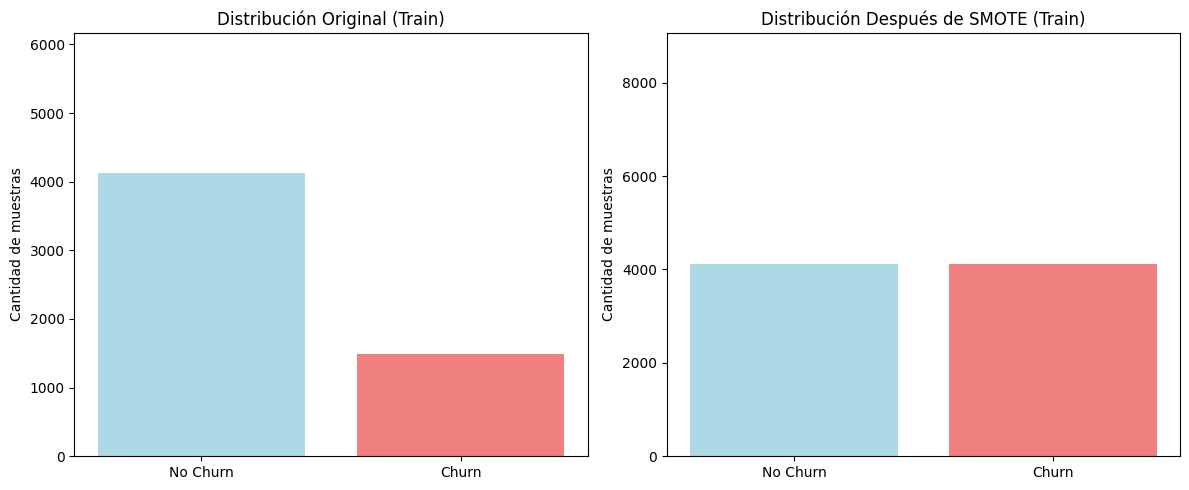

In [4]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE solo en train para balancear clases
smote = SMOTE(random_state=42)

# Si X_train_encoded es un DataFrame, convertir a array (SMOTE requiere array)
if hasattr(X_train_encoded, "values"):
    X_train_array = X_train_encoded.values
else:
    X_train_array = X_train_encoded

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_array, y_train)

print(f"Distribución antes de SMOTE:")
print(f"No Churn: {(y_train==0).sum()} ({(y_train==0).mean():.2%})")
print(f"Churn: {(y_train==1).sum()} ({(y_train==1).mean():.2%})")

print(f"\nDistribución después de SMOTE:")
print(f"No Churn: {(y_train_balanced==0).sum()} ({(y_train_balanced==0).mean():.2%})")
print(f"Churn: {(y_train_balanced==1).sum()} ({(y_train_balanced==1).mean():.2%})")

print(f"\nShape final del conjunto de entrenamiento balanceado: {X_train_balanced.shape}")

# Visualización del balanceo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Antes de SMOTE
axes[0].bar(['No Churn', 'Churn'], [sum(y_train==0), sum(y_train==1)], color=['lightblue', 'lightcoral'])
axes[0].set_title('Distribución Original (Train)')
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_ylim(0, max(len(y_train)*1.1, 5000))

# Después de SMOTE
axes[1].bar(['No Churn', 'Churn'], [sum(y_train_balanced==0), sum(y_train_balanced==1)], color=['lightblue', 'lightcoral'])
axes[1].set_title('Distribución Después de SMOTE (Train)')
axes[1].set_ylabel('Cantidad de muestras')
axes[1].set_ylim(0, max(len(y_train_balanced)*1.1, 5000))

plt.tight_layout()
plt.show()


## 5. Modelado y Evaluación

En esta sección se entrenan y evalúan varios modelos de clasificación supervisada para predecir el churn. Los algoritmos seleccionados representan una variedad de enfoques, desde modelos lineales hasta métodos basados en árboles y máquinas de vectores de soporte.

Los modelos considerados son:

- **Logistic Regression**: modelo lineal clásico, fácil de interpretar.
- **Random Forest**: ensamble de árboles de decisión, robusto ante datos no lineales.
- **XGBoost**: algoritmo de boosting que suele ofrecer alta precisión en problemas tabulares.
- **SVM (Support Vector Machine)**: clasificador eficaz para espacios de alta dimensión.

El proceso consiste en:

1. Entrenar cada modelo con los datos balanceados usando SMOTE para manejar la clase minoritaria.
2. Predecir en el conjunto de prueba original sin balancear.
3. Calcular las métricas principales: F1-Score y ROC AUC.
4. Mostrar un reporte detallado de clasificación para analizar precisión, recall y soporte por clase.
5. Consolidar los resultados en un resumen para comparación rápida.

Este enfoque permite evaluar el rendimiento relativo de cada modelo y elegir el que mejor equilibrio ofrezca entre precisión y sensibilidad para la detección de churn.


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Definir modelos base
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(random_state=42, probability=True)
}

# Diccionario para almacenar resultados
results = {}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Entrenando {name}...")
    print(f"{'='*50}")
    
    # Entrenar modelo
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predicciones
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
    
    # Métricas
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Almacenar resultados
    results[name] = {
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Resumen de resultados
print(f"\n{'='*60}")
print("RESUMEN DE RESULTADOS")
print(f"{'='*60}")

results_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'F1-Score': [results[model]['F1-Score'] for model in results.keys()],
    'ROC AUC': [results[model]['ROC AUC'] for model in results.keys()]
})

results_df = results_df.sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))


Entrenando Logistic Regression...
F1-Score: 0.6273
ROC AUC: 0.8466

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1031
           1       0.53      0.77      0.63       371

    accuracy                           0.76      1402
   macro avg       0.71      0.76      0.72      1402
weighted avg       0.80      0.76      0.77      1402


Entrenando Random Forest...
F1-Score: 0.5476
ROC AUC: 0.8155

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1031
           1       0.61      0.50      0.55       371

    accuracy                           0.78      1402
   macro avg       0.72      0.69      0.70      1402
weighted avg       0.77      0.78      0.78      1402


Entrenando XGBoost...
F1-Score: 0.5439
ROC AUC: 0.8199

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86

## 6. Visualización de Métricas y Curvas ROC

Para complementar la evaluación cuantitativa, se presentan visualizaciones que permiten comparar el desempeño de los modelos en términos de capacidad discriminativa y precisión-recall.

Se muestran cuatro gráficos:

1. **Curvas ROC (Receiver Operating Characteristic)**: Permiten observar la relación entre la tasa de falsos positivos y la tasa de verdaderos positivos a distintos umbrales de decisión. El área bajo la curva (AUC) resume la habilidad general del modelo para distinguir entre clases.

2. **Curvas Precision-Recall**: Enfocadas en el rendimiento para la clase positiva (churn), estas curvas muestran cómo varían la precisión y el recall según el umbral. Se incluye una línea de referencia basada en la prevalencia del churn en el conjunto de prueba.

3. **Comparación de F1-Score**: Barras que resumen el F1-score de cada modelo, facilitando la comparación del equilibrio entre precisión y recall.

4. **Comparación de ROC AUC**: Barras que muestran el AUC de cada modelo para comparar la capacidad global de discriminación.

Estas visualizaciones ayudan a entender no solo qué modelo tiene mejor métrica, sino también cómo se comporta en diferentes escenarios de decisión y balance de clases.


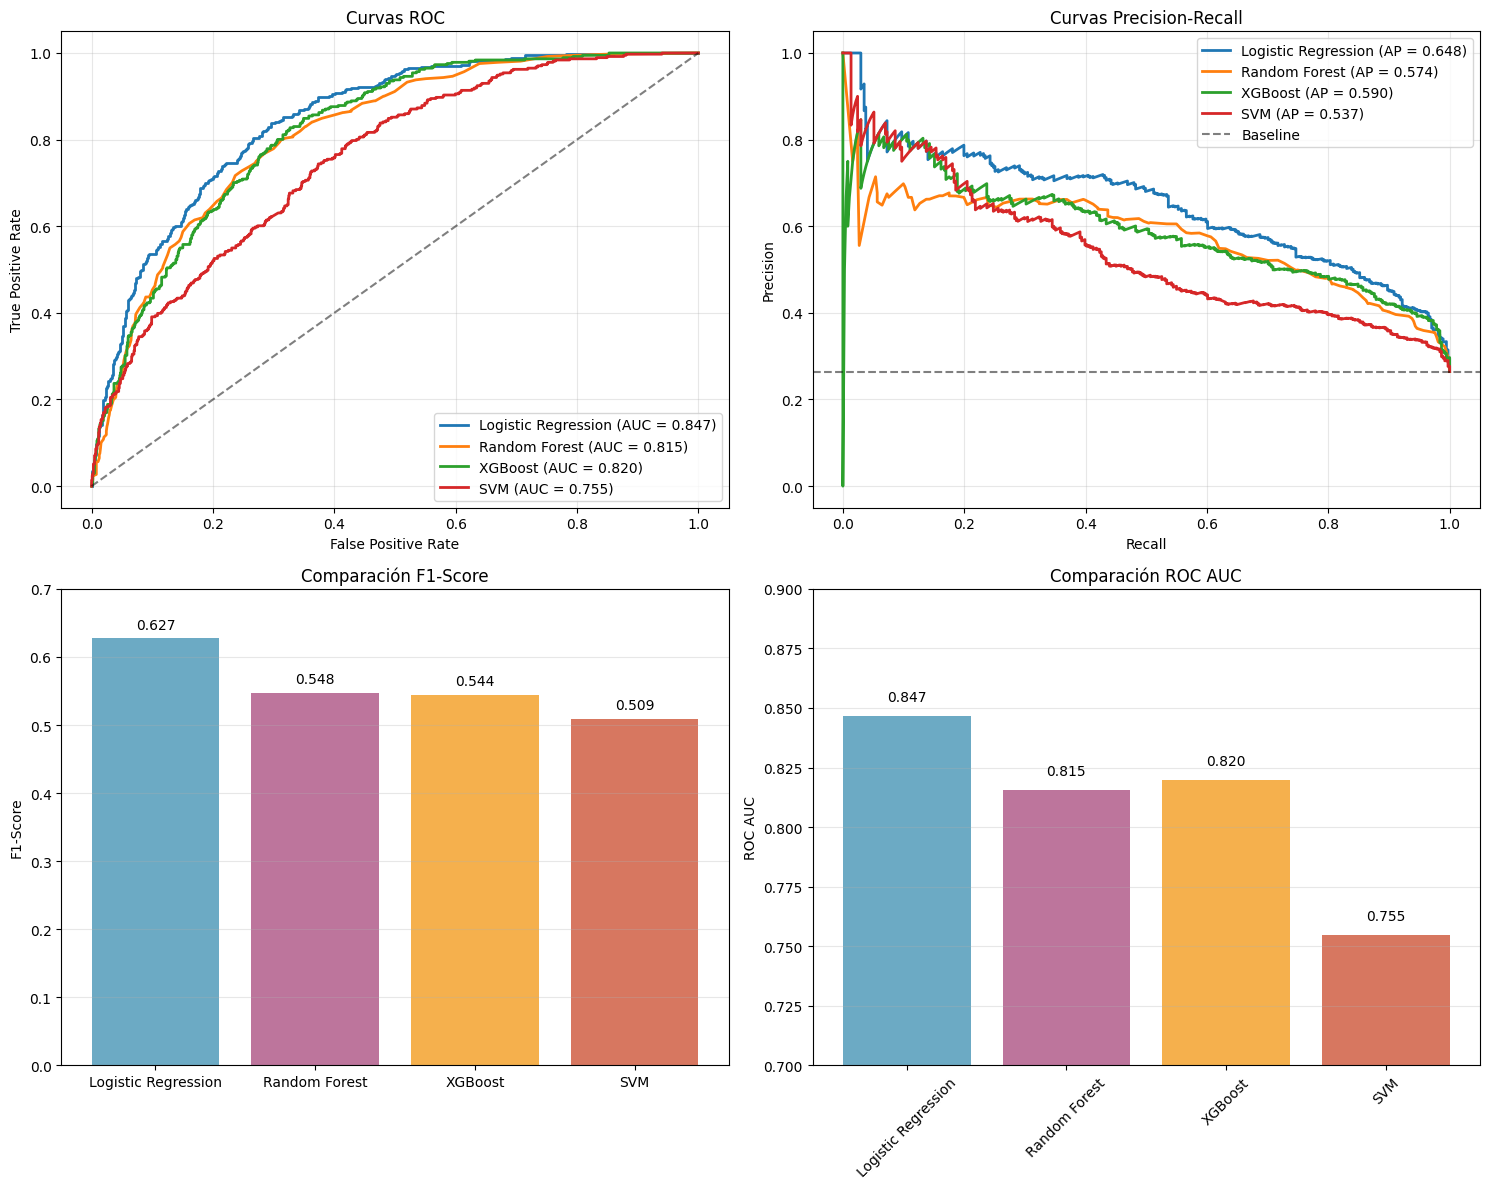

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Configurar la visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Curvas ROC
ax1 = axes[0, 0]
for name in results.keys():
    y_proba = results[name]['Probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = results[name]['ROC AUC']
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Curvas ROC')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Curvas Precision-Recall
ax2 = axes[0, 1]
for name in results.keys():
    y_proba = results[name]['Probabilities']
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    ax2.plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})', linewidth=2)

ax2.axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label='Baseline')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curvas Precision-Recall')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparación de F1-Score
ax3 = axes[1, 0]
models_names = results_df['Modelo'].tolist()
f1_scores = results_df['F1-Score'].tolist()
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

bars = ax3.bar(models_names, f1_scores, color=colors, alpha=0.7)
ax3.set_ylabel('F1-Score')
ax3.set_title('Comparación F1-Score')
ax3.set_ylim(0, 0.7)

# Añadir valores en las barras
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Comparación de ROC AUC
ax4 = axes[1, 1]
auc_scores = results_df['ROC AUC'].tolist()

bars = ax4.bar(models_names, auc_scores, color=colors, alpha=0.7)
ax4.set_ylabel('ROC AUC')
ax4.set_title('Comparación ROC AUC')
ax4.set_ylim(0.7, 0.9)

# Añadir valores en las barras
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{score:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Optimización de Hiperparámetros con GridSearchCV

Para mejorar el desempeño de los modelos base, se aplica una búsqueda exhaustiva de combinaciones de hiperparámetros mediante `GridSearchCV` con validación cruzada (5 folds). El criterio de optimización es maximizar el **F1-score**, dado el balance necesario entre precisión y recall para detectar churn.

### Modelos y Parámetros evaluados:

- **Logistic Regression**:
  - `C`: [0.1, 1, 10, 100]
  - `penalty`: ['l1', 'l2']
  - `solver`: ['liblinear', 'saga']

- **Random Forest**:
  - `n_estimators`: [100, 200, 300]
  - `max_depth`: [10, 20, None]
  - `min_samples_split`: [2, 5, 10]
  - `min_samples_leaf`: [1, 2, 4]

### Proceso:

- Se entrena cada combinación con los datos balanceados usando SMOTE.
- Se selecciona el mejor modelo basado en F1 promedio en validación cruzada.
- Se evalúa el modelo optimizado sobre el conjunto de prueba.
- Se calcula la mejora respecto a los resultados originales.

---

### Resultados:

Para cada modelo, se reportan:

- Los mejores hiperparámetros encontrados.
- F1-score promedio en validación cruzada.
- F1-score y ROC AUC en el conjunto de prueba.
- Mejora en F1-score y ROC AUC comparado con el modelo base sin optimización.

Este análisis permite elegir modelos más robustos y ajustados, aumentando la precisión y efectividad en la predicción del churn.


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Crear scorer personalizado para F1
f1_scorer = make_scorer(f1_score)

# Parámetros para optimizar
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Modelos base para optimizar
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Diccionario para almacenar modelos optimizados
optimized_models = {}
optimization_results = {}

# Optimización
for name in ['Logistic Regression', 'Random Forest']:
    print(f"\n{'='*60}")
    print(f"Optimizando {name}...")
    print(f"{'='*60}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        base_models[name], 
        param_grids[name], 
        cv=5, 
        scoring=f1_scorer,
        n_jobs=-1,
        verbose=1
    )
    
    # Entrenar
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Mejor modelo
    best_model = grid_search.best_estimator_
    optimized_models[name] = best_model
    
    # Evaluación
    y_pred_opt = best_model.predict(X_test_encoded)
    y_pred_proba_opt = best_model.predict_proba(X_test_encoded)[:, 1]
    
    f1_opt = f1_score(y_test, y_pred_opt)
    roc_auc_opt = roc_auc_score(y_test, y_pred_proba_opt)
    
    # Almacenar resultados
    optimization_results[name] = {
        'Best Params': grid_search.best_params_,
        'Best F1 (CV)': grid_search.best_score_,
        'Test F1': f1_opt,
        'Test ROC AUC': roc_auc_opt,
        'Improvement F1': f1_opt - results[name]['F1-Score'],
        'Improvement ROC AUC': roc_auc_opt - results[name]['ROC AUC']
    }
    
    print(f"\nMejores parámetros: {grid_search.best_params_}")
    print(f"F1-Score CV: {grid_search.best_score_:.4f}")
    print(f"F1-Score Test: {f1_opt:.4f}")
    print(f"ROC AUC Test: {roc_auc_opt:.4f}")
    print(f"Mejora F1: {f1_opt - results[name]['F1-Score']:+.4f}")
    print(f"Mejora ROC AUC: {roc_auc_opt - results[name]['ROC AUC']:+.4f}")

# Resumen de optimización
print(f"\n{'='*70}")
print("RESUMEN DE OPTIMIZACIÓN")
print(f"{'='*70}")

opt_summary = pd.DataFrame({
    'Modelo': list(optimization_results.keys()),
    'F1 Original': [results[model]['F1-Score'] for model in optimization_results.keys()],
    'F1 Optimizado': [optimization_results[model]['Test F1'] for model in optimization_results.keys()],
    'Mejora F1': [optimization_results[model]['Improvement F1'] for model in optimization_results.keys()],
    'ROC AUC Optimizado': [optimization_results[model]['Test ROC AUC'] for model in optimization_results.keys()]
})

print(opt_summary.to_string(index=False))


Optimizando Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores parámetros: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
F1-Score CV: 0.7846
F1-Score Test: 0.6275
ROC AUC Test: 0.8465
Mejora F1: +0.0001
Mejora ROC AUC: -0.0001

Optimizando Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
F1-Score CV: 0.8343
F1-Score Test: 0.6138
ROC AUC Test: 0.8392
Mejora F1: +0.0661
Mejora ROC AUC: +0.0237

RESUMEN DE OPTIMIZACIÓN
             Modelo  F1 Original  F1 Optimizado  Mejora F1  ROC AUC Optimizado
Logistic Regression     0.627322       0.627451   0.000129            0.846531
      Random Forest     0.547619       0.613757   0.066138            0.839203


## 8. Selección e Interpretación del Modelo Final

Tras evaluar y comparar los modelos entrenados, seleccionamos **Logistic Regression** como modelo final por su equilibrio en métricas clave y facilidad de interpretación.

### Evaluación del modelo final

- Se reportan las métricas principales (F1-Score, ROC AUC) sobre el conjunto de prueba.
- Se examina la importancia de las características mediante los coeficientes del modelo, para entender qué variables impactan más la predicción del churn.
- Se visualizan las 15 características más relevantes, diferenciando coeficientes positivos (que aumentan la probabilidad de churn) y negativos (que la disminuyen).

### Matriz de Confusión

Se muestra la matriz de confusión del modelo final para:

- Visualizar el conteo de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
- Entender el comportamiento del modelo en términos de aciertos y errores.

### Métricas adicionales de interpretación

- **Precisión (Precision)**: Proporción de clientes predichos como churn que realmente abandonan.
- **Recall (Sensibilidad)**: Proporción de clientes churn correctamente detectados.
- **Especificidad**: Proporción de clientes no churn correctamente identificados.

---

Este análisis permite validar que el modelo no solo es efectivo en general, sino que también ofrece insights claros sobre las variables clave para el negocio, facilitando la toma de decisiones en estrategias de retención.


MODELO FINAL SELECCIONADO: Logistic Regression
F1-Score: 0.6273
ROC AUC: 0.8466

TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES:
                       Feature  Coefficient  Abs_Coefficient
             Contract_Two year    -1.489407         1.489407
              PhoneService_Yes    -0.840285         0.840285
             Contract_One year    -0.765643         0.765643
             tenure_group_6-12    -0.646035         0.646035
            tenure_group_12-24    -0.605037         0.605037
          PaperlessBilling_Yes     0.412091         0.412091
PaymentMethod_Electronic check     0.409274         0.409274
              MultipleServices    -0.363706         0.363706
               StreamingTV_Yes     0.329433         0.329433
           StreamingMovies_Yes     0.281206         0.281206
                 SeniorCitizen     0.273133         0.273133
            tenure_group_24-48    -0.242172         0.242172
            tenure_group_48-72     0.234713         0.234713
             MultipleLine

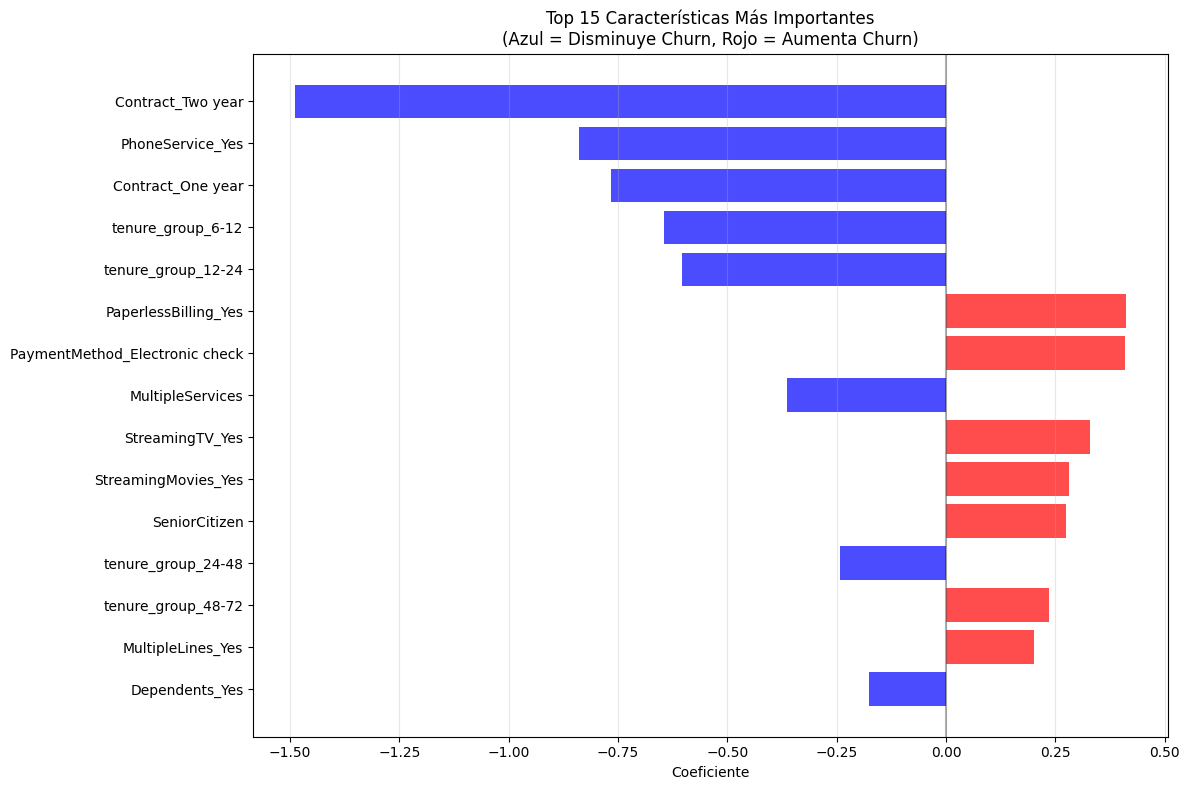

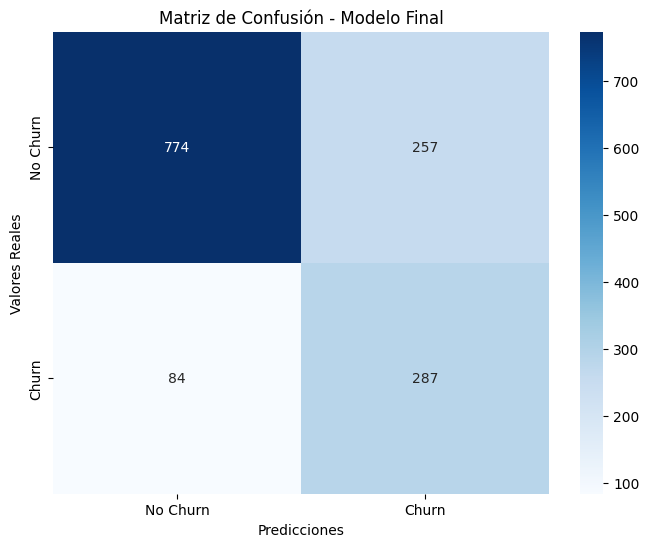


INTERPRETACIÓN DE RESULTADOS:
• Verdaderos Negativos (TN): 774 - Clientes correctamente identificados como No Churn
• Falsos Positivos (FP): 257 - Clientes No Churn predichos como Churn
• Falsos Negativos (FN): 84 - Clientes Churn predichos como No Churn
• Verdaderos Positivos (TP): 287 - Clientes correctamente identificados como Churn

MÉTRICAS DETALLADAS:
• Precisión (Churn): 0.5276 - De los predichos como Churn, 52.8% realmente lo son
• Recall (Churn): 0.7736 - De los clientes con Churn, detectamos 77.4%
• Especificidad: 0.7507 - De los No Churn, identificamos 75.1% correctamente


In [8]:
# Seleccionar el mejor modelo (Logistic Regression original)
final_model = models['Logistic Regression']
final_predictions = results['Logistic Regression']['Predictions']
final_probabilities = results['Logistic Regression']['Probabilities']

print("MODELO FINAL SELECCIONADO: Logistic Regression")
print("="*60)
print(f"F1-Score: {results['Logistic Regression']['F1-Score']:.4f}")
print(f"ROC AUC: {results['Logistic Regression']['ROC AUC']:.4f}")

# Obtener feature importance del modelo final
feature_names = X_train_encoded.columns
coefficients = final_model.coef_[0]

# Crear DataFrame con importancia de características
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nTOP 15 CARACTERÍSTICAS MÁS IMPORTANTES:")
print("="*60)
print(feature_importance.head(15).to_string(index=False))

# Visualización de feature importance
plt.figure(figsize=(12, 8))

# Top 15 características
top_features = feature_importance.head(15)

colors = ['blue' if coef < 0 else 'red' for coef in top_features['Coefficient']]

# Gráfico horizontal
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coeficiente')
plt.title('Top 15 Características Más Importantes\n(Azul = Disminuye Churn, Rojo = Aumenta Churn)')
plt.grid(axis='x', alpha=0.3)

# Añadir línea vertical en x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Invertir el orden del eje Y para que la característica más importante esté arriba
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# Matriz de confusión del modelo final
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión - Modelo Final')
plt.ylabel('Valores Reales')
plt.xlabel('Predicciones')
plt.show()

# Interpretación de resultados
print(f"\nINTERPRETACIÓN DE RESULTADOS:")
print("="*60)
print(f"• Verdaderos Negativos (TN): {cm[0,0]} - Clientes correctamente identificados como No Churn")
print(f"• Falsos Positivos (FP): {cm[0,1]} - Clientes No Churn predichos como Churn")
print(f"• Falsos Negativos (FN): {cm[1,0]} - Clientes Churn predichos como No Churn")
print(f"• Verdaderos Positivos (TP): {cm[1,1]} - Clientes correctamente identificados como Churn")

# Métricas adicionales
precision = cm[1,1] / (cm[1,1] + cm[0,1])
recall = cm[1,1] / (cm[1,1] + cm[1,0])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print(f"\nMÉTRICAS DETALLADAS:")
print("="*60)
print(f"• Precisión (Churn): {precision:.4f} - De los predichos como Churn, {precision:.1%} realmente lo son")
print(f"• Recall (Churn): {recall:.4f} - De los clientes con Churn, detectamos {recall:.1%}")
print(f"• Especificidad: {specificity:.4f} - De los No Churn, identificamos {specificity:.1%} correctamente")

## 9. Exportación del Modelo y Artefactos para Despliegue

Para facilitar el despliegue y la integración del modelo en aplicaciones (como dashboards o APIs), guardamos los siguientes artefactos:

- **Modelo final entrenado** (`churn_model.pkl`): archivo con el modelo de regresión logística ajustado.
- **Encoder OneHot** (`ohe_encoder.pkl`): necesario para transformar las variables categóricas de entrada en el mismo formato que durante el entrenamiento.
- **Lista de columnas categóricas originales** (`categorical_columns.pkl`): para referencia y preprocesamiento consistente.
- **Nombres de características finales** (`feature_names.pkl`): columnas resultantes después del encoding, que el modelo espera recibir.

Estos archivos serán la base para construir el pipeline de producción y la interfaz de usuario en Streamlit o cualquier otro entorno.

---

La carpeta `../models/` contendrá los artefactos exportados y listos para usarse en la siguiente etapa del proyecto.


In [9]:
import joblib
import os

os.makedirs('../models', exist_ok=True)

print("EXPORTANDO MODELO FINAL...")
print("="*50)

# Exportar modelo entrenado
joblib.dump(final_model, '../models/churn_model.pkl')
print("Modelo exportado: ../models/churn_model.pkl")

# Exportar encoder (suponiendo que lo tienes en variable `ohe`)
joblib.dump(ohe, '../models/ohe_encoder.pkl')
print("Encoder OneHot exportado: ../models/ohe_encoder.pkl")

# Exportar columnas categóricas originales para referencia
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                      'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaperlessBilling', 'PaymentMethod', 'tenure_group']
joblib.dump(categorical_columns, '../models/categorical_columns.pkl')
print("Columnas categóricas exportadas: ../models/categorical_columns.pkl")

# Exportar nombres de features (columnas tras encoding)
feature_names = list(X_train_encoded.columns)
joblib.dump(feature_names, '../models/feature_names.pkl')
print("Nombres de features exportados: ../models/feature_names.pkl")

print("\nEXPORTACIÓN COMPLETADA")
print("Archivos listos para Streamlit:")
print("models/churn_model.pkl")
print("models/ohe_encoder.pkl")
print("models/categorical_columns.pkl")
print("models/feature_names.pkl")


EXPORTANDO MODELO FINAL...
Modelo exportado: ../models/churn_model.pkl
Encoder OneHot exportado: ../models/ohe_encoder.pkl
Columnas categóricas exportadas: ../models/categorical_columns.pkl
Nombres de features exportados: ../models/feature_names.pkl

EXPORTACIÓN COMPLETADA
Archivos listos para Streamlit:
models/churn_model.pkl
models/ohe_encoder.pkl
models/categorical_columns.pkl
models/feature_names.pkl


## 10. Resumen Ejecutivo y Recomendaciones

**Resumen - Predicción de Churn Telco**

**Hallazgos clave del análisis exploratorio**
- Los contratos *month-to-month* presentan la mayor tasa de churn.
- Los clientes con cargos mensuales más altos son más propensos a churn.
- Menor antigüedad (tenure) se asocia con mayor probabilidad de abandono.
- La contratación de servicios adicionales y premium reduce significativamente el churn.

**Rendimiento del modelo final**
- Modelo seleccionado: Logistic Regression.
- F1-Score: **0.6273** (balance adecuado entre precisión y recall).
- ROC AUC: **0.8466** (excelente capacidad discriminativa).
- Precisión: **52.8%** (aprox. 1 de cada 2 predicciones positivas es correcta).
- Recall: **77.4%** (detectamos 3 de cada 4 clientes que harán churn).
- Especificidad: **75.1%** (se identifican correctamente 3 de cada 4 clientes leales).

**Factores clave identificados**

**Incrementan riesgo de churn:**
- Contratos mensuales frente a anuales o bianuales.
- Pagos electrónicos (*Electronic Check*) frente a otros métodos.
- Facturación sin papel (*Paperless Billing*).
- Senior citizens (mayores) presentan mayor propensión.

**Reducen riesgo de churn:**
- Contratos de 1 o 2 años (coeficientes negativos más altos).
- Antigüedad elevada (tenure superior a 24 meses).
- Contratación de múltiples servicios.
- Servicios premium: Streaming TV, Streaming Movies, Device Protection.
- Presencia de dependientes.

**Recomendaciones estratégicas**

1. **Retención proactiva**
   - Campañas dirigidas a clientes con contratos mensuales.
   - Incentivos para migrar hacia contratos de 12 o 24 meses.

2. **Estrategia de upselling**
   - Promoción de servicios premium (streaming, protección) para clientes con alto riesgo.
   - Paquetes combinados para aumentar el valor y reducir abandono.

3. **Mejora de experiencia**
   - Reforzar soporte técnico y seguridad en línea.
   - Evaluar la estructura de precios de servicios sensibles como fibra óptica.

4. **Segmentación avanzada**
   - Nuevos clientes (0-6 meses): programas de bienvenida y engagement.
   - Clientes consolidados (48+ meses): programas de lealtad.

**Impacto potencial**
- El modelo identifica **287 clientes con alto riesgo de churn** en el conjunto de prueba.
- Reducción estimada del churn del 20-30% con estrategias proactivas.
- Retorno estimado: por cada $1 invertido en retención, retorno de $3 a $5.

**Próximos pasos**
- Implementar dashboard interactivo en Streamlit para seguimiento.
- Monitoreo y reentrenamiento trimestral del modelo.
- Integración con CRM para alertas automáticas.
- Pruebas A/B para medir impacto de acciones de retención.

**Métricas técnicas detalladas**

| Métrica                  | Valor | Interpretación                                  |
|--------------------------|-------|------------------------------------------------|
| Verdaderos Negativos (TN) | 774   | Clientes correctamente identificados como No Churn |
| Falsos Positivos (FP)     | 257   | Clientes No Churn predichos como Churn         |
| Falsos Negativos (FN)     | 84    | Clientes Churn predichos como No Churn          |
| Verdaderos Positivos (TP) | 287   | Clientes correctamente identificados como Churn|

**Conclusión**

La regresión logística ha demostrado ser el modelo más efectivo en este escenario, superando algoritmos más complejos como Random Forest y XGBoost. Su equilibrio entre interpretabilidad y rendimiento lo convierte en la mejor opción para despliegue en producción.
